In [98]:
import numpy as np

def nonLinearKalmanFilter(Y, x_0, u, P_0, f, Q, h, R):
    n = x_0.shape[0]
    m = Y.shape[0]
    N = Y.shape[1]

    xf = np.zeros((n, N))
    Pf = np.zeros((n, n, N))
    xp = np.zeros((n, N))
    Pp = np.zeros((n, n, N))

    xp[:, 0], Pp[:, :, 0] = nonLinKFprediction(x_0, u[:, 0], P_0, f, Q)
    xf[:, 0], Pf[:, :, 0] = nonLinKFupdate(xp[:, 0], Pp[:, :, 0], Y[:, 0], h, R)

    for i in range(1, N):
        xp[:, i], Pp[:, :, i] = nonLinKFprediction(xf[:, i - 1], u[:, i], Pf[:, :, i - 1], f, Q)
        xf[:, i], Pf[:, :, i] = nonLinKFupdate(xp[:, i], Pp[:, :, i], Y[:, i], h, R)

    return xf, Pf, xp, Pp


def nonLinKFprediction(x, u, P, f, Q):
    fx, Fx = f(x, u)
    x = fx
    P = Fx @ P @ Fx.T + Q
    return x, P


def nonLinKFupdate(x, P, y, h, R):
    hx, Hx = h(x)
    S = Hx @ P @ Hx.T + R
    K = P @ Hx.T @ np.linalg.inv(S)
    P = P - K @ S @ K.T
    x = x + K @ (y - hx)
    return x, P


def MotionModel(x, u, T):
    R = 0.27
    Fx = np.array([[0, 0, 0, 0],
                   [0, 1, 0, 0],
                   [0, -((u[0] + u[1]) / 2) * np.sin(x[1] + (u[0] - u[1]) / 2 / R) * T, 1, 0],
                   [0, ((u[0] + u[1]) / 2) * np.cos(x[1] + (u[0] - u[1]) / 2 / R) * T, 0, 1]])

    fx = np.array([(u[0] + u[1]) / 2,
                   x[1] + ((u[0] - u[1]) / 2 / R) * T,
                   x[2] + ((u[0] + u[1]) / 2) * np.cos(x[1] + (u[0] - u[1]) / 2 / R) * T * T,
                   x[3] + ((u[0] + u[1]) / 2) * np.sin(x[1] + (u[0] - u[1]) / 2 / R) * T * T])

    return fx, Fx


def MeasurementModel(x):
    hx = np.array([x[2], x[3]])
    Hx = np.array([[0, 0, 1, 0],
                   [0, 0, 0, 1]])
    return hx, Hx

In [142]:
import pandas as pd
import numpy as np

gnss_data = pd.read_csv('gnss-1.csv')
wheelspeeds_data = pd.read_csv('wheelspeeds-1.csv')
groundtruth_data = pd.read_csv('groundtruth-1.csv')

gnss1_data = gnss_data.iloc[:, [1,2]].values.T
wheelspeeds1_data = wheelspeeds_data.iloc[1:7780:20, [1,2]].values.T
groundtruth_data = np.array(groundtruth_data)


gnss1 = np.array(gnss1_data)
wheelspeeds1 = np.array(wheelspeeds1_data)

Y = gnss1
T = 0.1

def f(x, u):
    return MotionModel(x, u, T)

def h(x):
    return MeasurementModel(x)


x_0 = np.zeros((4, 1))
P_0 = np.diag([1, 1, 1, 1])

u = wheelspeeds1


Q = 1 * T * np.diag([0, 0, 1, 1])
R = 1 * np.diag([1, 1])

In [143]:
groundtruth_data

array([[ 0.00000000e+00,  4.89236791e-06,  0.00000000e+00,
         0.00000000e+00],
       [ 5.00000000e-03,  1.46766011e-05,  0.00000000e+00,
         0.00000000e+00],
       [ 1.00000000e-02,  2.93521969e-05,  0.00000000e+00,
         0.00000000e+00],
       ...,
       [ 3.99900000e+01,  2.60903071e+01,  1.02898128e+01,
        -5.01326249e+00],
       [ 3.99950000e+01,  2.60918151e+01,  1.02946727e+01,
        -5.01326249e+00],
       [ 4.00000000e+01,  2.60933226e+01,  1.02995309e+01,
        -5.01326249e+00]])

In [115]:
nonLinearKalmanFilter(Y, x_0,u, P_0, f, Q, h, R)

C:\Users\13906\AppData\Local\Temp\ipykernel_31508\1582011965.py:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Fx = np.array([[0, 0, 0, 0],
C:\Users\13906\AppData\Local\Temp\ipykernel_31508\1582011965.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  fx = np.array([(u[0] + u[1]) / 2,


(array([[ 1.76500000e-03,  1.94150000e-02,  3.70650000e-02, ...,
          1.12329750e+00,  1.11559750e+00,  1.10789750e+00],
        [ 2.24516290e-05, -4.15604008e-04, -4.26626451e-04, ...,
         -5.71293594e+00, -5.71920225e+00, -5.72600224e+00],
        [ 2.88897899e-02,  2.02283188e-01,  1.37098001e-01, ...,
          2.62058655e+01,  2.62579353e+01,  2.62779094e+01],
        [ 1.51465922e-01,  2.27999357e-02,  2.55650891e-02, ...,
          9.93935287e+00,  1.01149132e+01,  1.01907560e+01]]),
 array([[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00, 

In [119]:
[xf, Pf, xp, Pp] = nonLinearKalmanFilter(Y, x_0,u, P_0, f, Q, h, R)

C:\Users\13906\AppData\Local\Temp\ipykernel_31508\1582011965.py:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Fx = np.array([[0, 0, 0, 0],
C:\Users\13906\AppData\Local\Temp\ipykernel_31508\1582011965.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  fx = np.array([(u[0] + u[1]) / 2,


In [159]:
Pf

array([[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

       [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 9.99999985e-01,  9.99997458e-01,  9.99980924e-01, ...,
          1.23788826e-02,  1.23591315e-02,  1.23397078e-02],
        [ 1.55643737e-09,  2.17671122e-07,  2.15573397e-06, ...,
         -1.84909132e-03, -1.82042343e-03, -1.79428355e-03],
        [ 8.40476178e-05,  1.24740150e-03,  3.33777684e-03, ...,
          3.34882504e-03,  3.32840507e-03,  3.30674

In [155]:
from scipy.linalg import sqrtm

def sigma2D(mu, sigma):
    theta = np.linspace(0, 2*np.pi, 100)
    xy = mu[:, np.newaxis] + 1 * sqrtm(sigma) @ np.array([np.cos(theta), np.sin(theta)])
    return xy

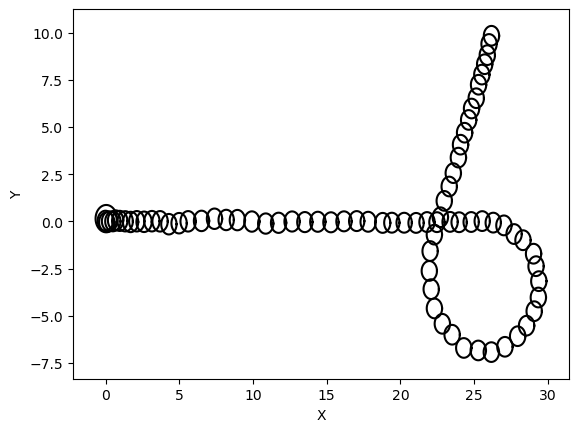

In [198]:
for i in range(0, xf.shape[1], 5):
    cov_plot = sigma2D(xf[2:4, i], Pf[2:4, 2:4, i])
    plt.plot(cov_plot[0, :], cov_plot[1, :], '-k')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

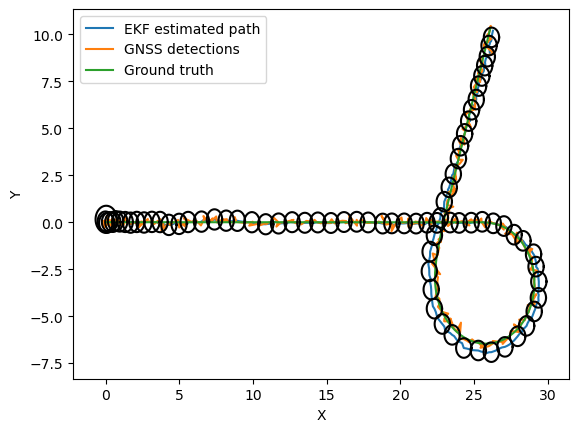

In [197]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(xf[2, :], xf[3, :],label='EKF estimated path')
plt.plot(Y[0,:],Y[1,:], label='GNSS detections')
plt.plot(groundtruth_data[:,1],groundtruth_data[:,2], label='Ground truth')
for i in range(0, xf.shape[1], 5):
    cov_plot = sigma2D(xf[2:4, i], Pf[2:4, 2:4, i])
    plt.plot(cov_plot[0, :], cov_plot[1, :], '-k')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

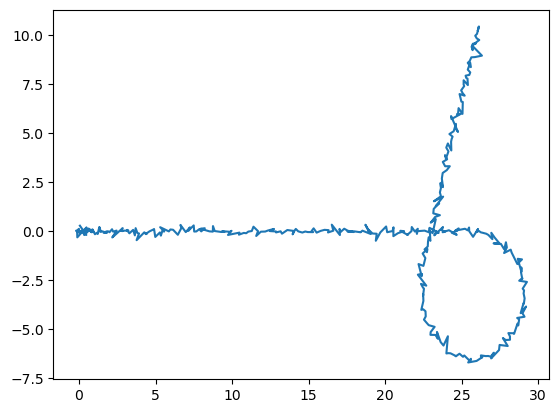

In [133]:
plt.plot(Y[0,:],Y[1,:])

In [ ]:
plt.plot(Y[0,:],Y[1,:])

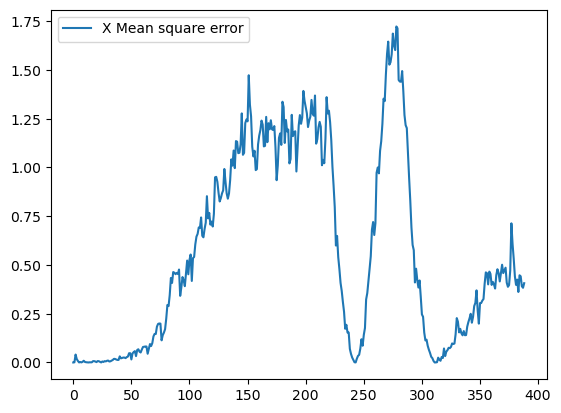

In [169]:
import numpy as np

test_mse_X = np.zeros(xf.shape[1])
for j in range(xf.shape[1]):
    test_error = xp[2, j] - groundtruth_data[1 + j * 20, 1]
    test_mse_X[j] = np.mean(np.square(test_error))
plt.plot(test_mse_X, label='X Mean square error')
plt.ylabel('Time')
plt.legend()

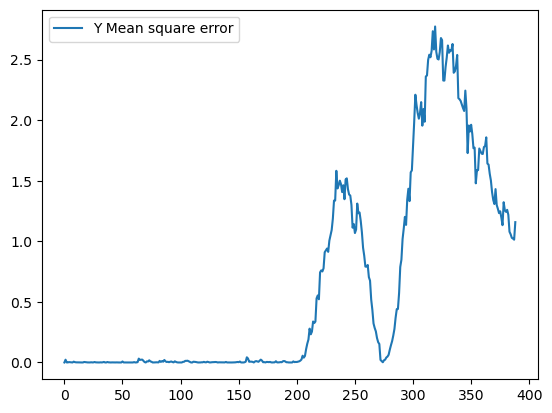

In [170]:
test_mse_Y = np.zeros(xf.shape[1])
for j in range(xf.shape[1]):
    test_error = xp[3, j] - groundtruth_data[1 + j * 20, 2]
    test_mse_Y[j] = np.mean(np.square(test_error))
plt.plot(test_mse_Y, label='Y Mean square error')
plt.legend()

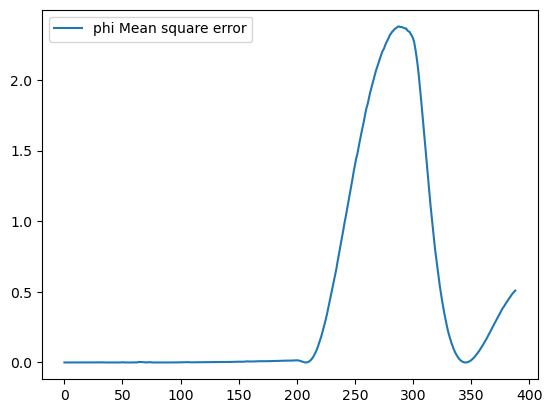

In [171]:
test_mse_phi = np.zeros(xf.shape[1])
for j in range(xf.shape[1]):
    test_error = xp[1, j] - groundtruth_data[1 + j * 20, 3]
    test_mse_phi[j] = np.mean(np.square(test_error))
plt.plot(test_mse_phi, label='phi Mean square error')
plt.legend()

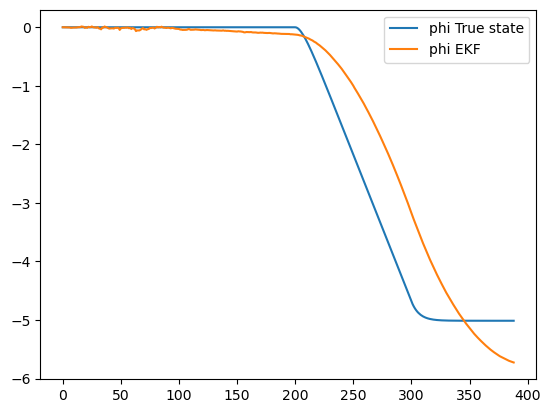

In [182]:
plt.plot(groundtruth_data[1:7780:20, [3]])
plt.plot(xf[1,:])
plt.legend(['phi True state', 'phi EKF'])
plt.show()

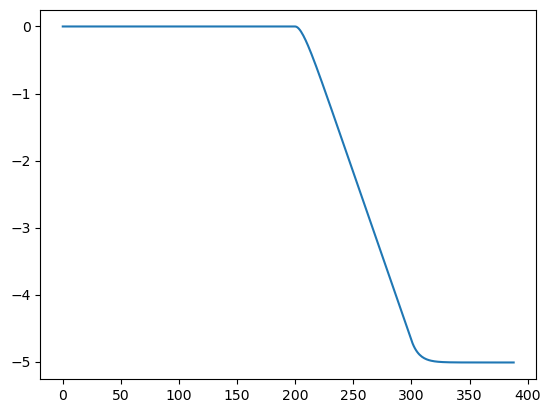

In [188]:
plt.plot(groundtruth_data[1:7780:20, 3])

In [189]:
groundtruth_data[:,3]

array([ 0.        ,  0.        ,  0.        , ..., -5.01326249,
       -5.01326249, -5.01326249])

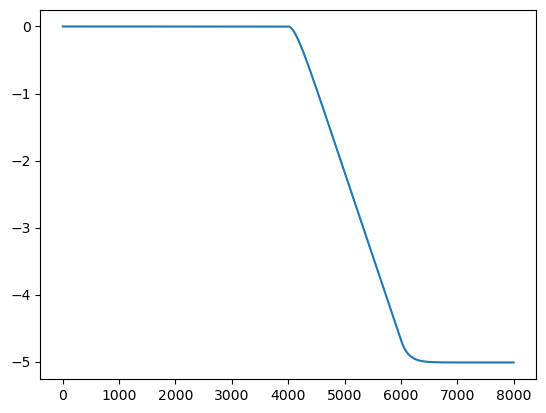

In [194]:
plt.plot(groundtruth_data[:,3])